In [60]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing

#Visualisation Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import seaborn as sns

# Self written packages
from data.make_data import DataSet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
print("Start reading data:")
parentdir = os.path.dirname(os.getcwd())
datadir = os.path.join(parentdir, "data")
dataset = DataSet(datadir,file_ending=".csv")
tracks, trackspoints = dataset.get_data()
tracks = dataset.preprocess_tracks_data(tracks)
trackspoints = dataset.preprocess_trackspoint_data(trackspoints)

Start reading data:
Read  /Users/moritz/Desktop/BI2/bi2_project/data/go_track_tracks.csv
Read  /Users/moritz/Desktop/BI2/bi2_project/data/go_track_trackspoints.csv


## Data Set Description
The dataset is composed by two tables. The first table **tracks** presents general 
attributes and each instance has one trajectory that is represented by the table  
**trackspoints**. 

### Tracks Data Table - a list of trajectories  
- id_android - it represents the device used to capture the instance;  
- speed - it represents the average speed (Km/H)  
- time - it represents the time in hours
- distance - it represent the total distance (Km)  
- rating - it is an evaluation parameter. Evaluation the traffic is a way to verify the volunteers 
- perception about the traffic during the travel, in other words,  
 if volunteers move to some place and face traffic jam, maybe they will    evaluate 'bad'. (3-good, 2-normal, 1-bad).  
- rating_bus - it is other evaluation parameter. (1 - The amount of people inside the bus is little, 2 - The bus is not crowded, 3- The bus is crowded.  
- rating_weather - it is another evaluation parameter. ( 2- sunny, 1- raining).  
- car_or_bus - (1 - car, 2-bus)  
- linha - information about the bus that does the pathway  

First 10 entries:

In [155]:
tracks.iloc[0:10,:]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,car_or_bus,linha
0,1,0,19.210586,0.138049,2.652,3,0,0,1,no_answer
1,2,0,30.848229,0.171485,5.290,3,0,0,1,no_answer
2,3,1,13.560101,0.067699,0.918,3,0,0,2,no_answer
3,4,1,19.766679,0.389544,7.700,3,0,0,2,no_answer
4,8,0,25.807401,0.154801,3.995,2,0,0,1,no_answer
5,10,2,1.346913,0.006682,0.009,2,0,0,1,no_answer
6,11,3,36.850787,0.228001,8.402,3,0,0,1,no_answer
7,12,1,17.405131,0.038782,0.675,3,0,0,2,no_answer
8,13,1,15.395436,0.526844,8.111,3,0,0,2,no_answer
9,14,1,8.902729,0.003033,0.027,2,0,0,2,no_answer


Summary Statistics:

In [63]:
tracks.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,163.0,15607.650307,18644.257138,1.000000,48.500000,158.000000,37991.000000,38092.000000
id_android,163.0,7.386503,7.348742,0.000000,1.000000,4.000000,10.000000,27.000000
speed,163.0,16.704738,16.016168,0.009779,1.591016,16.685368,23.915760,96.206029
time,163.0,0.264272,0.292731,0.002175,0.035978,0.214466,0.390572,1.942948
distance,163.0,5.302411,7.639011,0.001000,0.034500,3.995000,7.333000,55.770000
rating,163.0,2.515337,0.679105,1.000000,2.000000,3.000000,3.000000,3.000000
rating_bus,163.0,0.386503,0.687859,0.000000,0.000000,0.000000,1.000000,3.000000
rating_weather,163.0,0.515337,0.841485,0.000000,0.000000,0.000000,1.000000,2.000000
car_or_bus,163.0,1.466258,0.500397,1.000000,1.000000,1.000000,2.000000,2.000000


### The following data shows how well documented the data set tracks is

In [151]:
# lets see how well documented the data is
# tracks size
print("number of unique tracks: " ,len(tracks))
print("number of unique tracks where avg. speed < 1km/h: ", len(tracks[tracks['speed'] < 1]))
print("number of unique tracks where time < 1 minute: ", len(tracks[tracks['time']*60 < 1]))
print("number of unique tracks where distance < 10 meters: ", len(tracks[tracks['distance'] < 0.01]))
print("number of unique tracks where rating = 0: ", len(tracks[tracks['rating'] == 0]))
print("number of unique tracks where rating weather = 0: ", len(tracks[tracks['rating_weather'] == 0]))
print("number of unique tracks where rating bus = 0: ", len(tracks[tracks['rating_bus'] == 0]))
print("number of unique tracks where car_or_bus = 0: ", len(tracks[tracks['car_or_bus'] == 0]))
print("number of unique tracks where car_or_bus = 1 (car): ", len(tracks[tracks['car_or_bus'] == 1]))
print("number of unique tracks where car_or_bus = 2 (bus): ", len(tracks[tracks['car_or_bus'] == 2]))
print("number of unique tracks where linha = no_answer: ", len(tracks[tracks['linha'] == 'no_answer']))

number of unique tracks:  163
number of unique tracks where avg. speed < 1km/h:  27
number of unique tracks where time < 1 minute:  31
number of unique tracks where distance < 10 meters:  24
number of unique tracks where rating = 0:  0
number of unique tracks where rating weather = 0:  116
number of unique tracks where rating bus = 0:  116
number of unique tracks where car_or_bus = 0:  0
number of unique tracks where car_or_bus = 1 (car):  87
number of unique tracks where car_or_bus = 2 (bus):  76
number of unique tracks where linha = no_answer:  83


By looking at these numbers one can see that the tracks dataframe needs some preprocessing. 

### Trackspoints Data Table -  localization points of each trajectory  
- id: unique key to identify each point  
- latitude: latitude from where the point is  
- longitude: longitude from where the point is  
- track_id: identify the trajectory which the point belong  
- time: datetime when the point was collected (GMT-3) 

First 10 entries:

In [64]:
trackspoints.iloc[0:10,:]

,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53
5,6,-10.938544,-37.062839,1,2014-09-13 07:24:59
6,7,-10.938346,-37.062588,1,2014-09-13 07:25:04
7,8,-10.938448,-37.062000,1,2014-09-13 07:25:10
8,9,-10.938666,-37.061499,1,2014-09-13 07:25:15
9,10,-10.938986,-37.060819,1,2014-09-13 07:25:21


Min and Max Values:

In [65]:
print("Min Values: \n" + str(trackspoints.min()))
print("\n")
print("Max Values: \n" + str(trackspoints.max()))
print("\nNumber of rows: %s" % trackspoints.shape[0])

Min Values: 
id                             1
latitude                -27.6032
longitude               -48.6329
track_id                       1
time         2014-09-13 07:24:32
dtype: object


Max Values: 
id                         19569
latitude                -10.2928
longitude               -36.4934
track_id                   38092
time         2016-01-19 13:01:47
dtype: object

Number of rows: 18107


**No duplicate ID's:**

In [66]:
print("Trackspoints[\"id\"] rows: " + str(trackspoints["id"].shape[0]))
print("Trackspoints[\"id\"] without duplicates rows: " + str(trackspoints["id"].drop_duplicates().shape[0]))

Trackspoints["id"] rows: 18107
Trackspoints["id"] without duplicates rows: 18107


***
## Visualization & Exploration
### Travel time for each trip in minutes

In [67]:
from utils.general_utils import calculate_total_trip_time
trips_per_track_id = calculate_total_trip_time(trackspoints)

In [68]:
sorted_trip_times = trips_per_track_id.sort_values(by="trip_time_in_minutes",ascending=False)

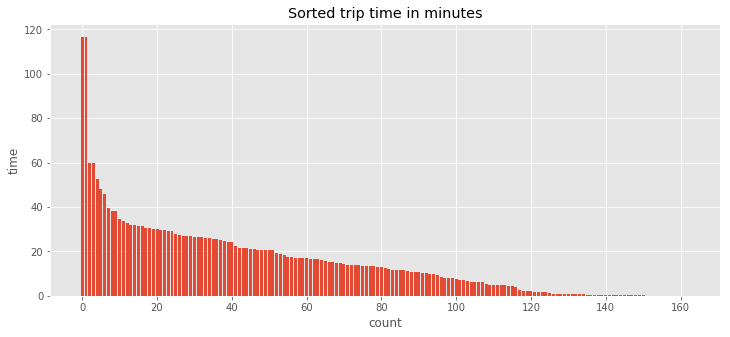

In [210]:
fig , ax = plt.subplots(figsize=(12,5))
ax.bar(range(tracks.shape[0]), sorted_trip_times["trip_time_in_minutes"])
ax.set_ylabel('time')
ax.set_xlabel('count')
ax.set_title("Sorted trip time in minutes")
plt.show();

We can see that the data set includes a lot of trips with a short time.

**10 Longest Trips for travel time in minutes**

In [70]:
sorted_trip_times.iloc[0:10,:].transpose()

track_id,27,26,30,31,37962,38002,38017,41,40,19
trip_time_in_minutes,116.57,116.57,59.67,59.67,52.42,47.93,45.8,39.42,38.25,38.07


In [71]:
trips_per_track_id.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
trip_time_in_minutes,163.0,15.34638,17.133331,0.0,1.84,12.33,23.2,116.57


**Note:** Number of rows in both tables are equal

In [72]:
x = tracks.set_index(keys="id")
x = x["time"] * 60

Check deviation of trip time in minutes from both tables: tracks[time] - calculated_trip_time 

In [73]:
deviation = np.abs(trips_per_track_id["trip_time_in_minutes"]) - np.abs(x.iloc[:])
absolute_deviation = np.abs(deviation)
print("Maximum Absolute Deviation: " + str(max(absolute_deviation)))

Maximum Absolute Deviation: 24.3293166667


**Large difference between the calculated trip time and the one stated in the tracks[time] column**

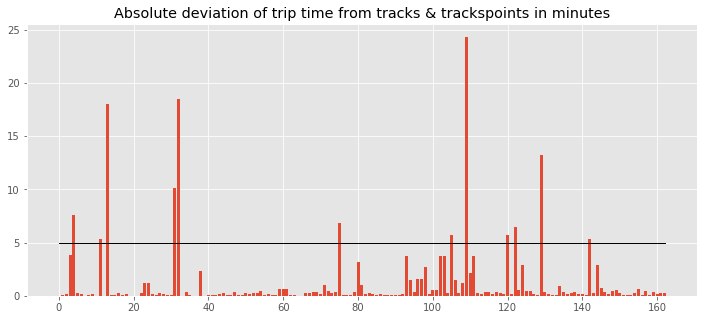

In [74]:
fig , ax = plt.subplots(figsize=(12,5))
ax.bar(range(x.shape[0]), absolute_deviation)
ax.set_title("Absolute deviation of trip time from tracks & trackspoints in minutes")
#ax.set_xlim((min(absolute_deviation), max(absolute_deviation)))
threshold = 5
plt.plot([threshold for x in range(x.shape[0])], 'k-', lw=1)
plt.show();

In [75]:
print("There are {} deviations larger than {} minutes".format(len(absolute_deviation[absolute_deviation > 5]),
                                                              threshold))

There are 12 deviations larger than 5 minutes


There are 

**From the 10 longest trips the Nr. 1 & 2, Nr. 3 & 4 have the same trip time**

Possibility of duplicate trip recordings

In [76]:
sorted_trip_times.iloc[0:4,:].transpose()

track_id,27,26,30,31
trip_time_in_minutes,116.57,116.57,59.67,59.67


Let's check if track recording 26 & 27 are duplicates or if it is just a coincidence that their trip time is the same.

In [77]:
track_26 = trackspoints[trackspoints["track_id"]==26]
track_27 = trackspoints[trackspoints["track_id"]==27]
track_list = [track_26, track_27]

Both trip recordings have the identical plot for time and longitude vs latitude. There is a high chance that these are not the only duplicate values.

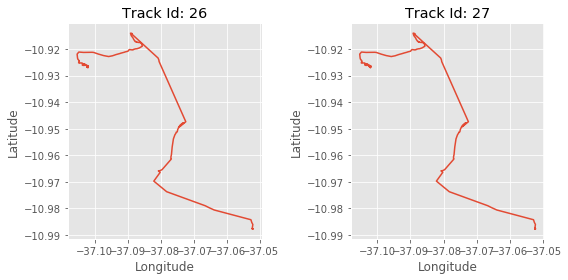

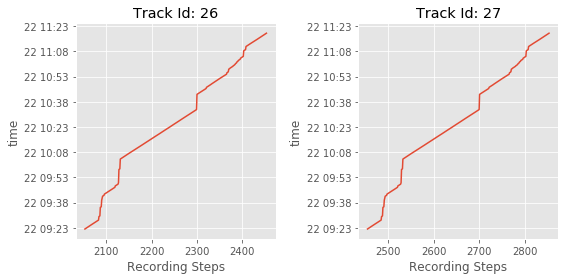

In [78]:
fig1, axes1 = plt.subplots(figsize=(8,4),nrows=1, ncols=2)
axes1_flattened = axes1.flatten()

for i, ax in enumerate(axes1_flattened):
    ax.plot(track_list[i]["longitude"], track_list[i]["latitude"])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    track_id = track_list[i]["track_id"].iloc[0]
    ax.set_title("Track Id: {}".format(track_id))
    
fig1.tight_layout();

fig2, axes2 = plt.subplots(figsize=(8,4),nrows=1, ncols=2)
axes2_flattened = axes2.flatten()
for i, ax in enumerate(axes2_flattened):
    ax.plot(track_list[i]["time"])
    ax.set_xlabel("Recording Steps")
    ax.set_ylabel("time")
    track_id = track_list[i]["track_id"].iloc[0]
    ax.set_title("Track Id: {}".format(track_id))
    
fig2.tight_layout();

In [230]:
trackspoints[trackspoints['track_id'] == 26]['latitude'][2053]

-10.987696666666698

In order to check for all duplicate track recordings a more analytical approach is needed. So let's first calculate all possible duplicates and check later whether they are real duplicates or not:


In [79]:
from utils.general_utils import get_duplicate_track_recording_candidates
nrofduplicates, duplicate_candidates = get_duplicate_track_recording_candidates(trips_per_track_id)
print("There are {} possible duplicates\n".format(nrofduplicates/2))

There are 27.0 possible duplicates



Now let's check whether these duplicate candidates are really identical in time and gps coordinates.  Lets check how many candidate duplicates track recordings are real duplicates:

In [80]:
from utils.general_utils import get_real_duplicate_track_recordings

duplicates = get_real_duplicate_track_recordings(duplicate_candidates, 
                                                 trackspoints, verbose = False)
print("There are {} real duplicates".format(len(duplicates)))

There are 17 real duplicates


We have the following duplicates:

In [81]:
print("Duplicate Track_ids:\n",[i for i in duplicates])

Duplicate Track_ids:
 [37972, 21, 27, 31, 45, 50, 56, 135, 137, 139, 141, 143, 32447, 37950, 37954, 37997, 38021]


Additionally to the duplicate track recordings we also have trip times which are 0:

In [82]:
print("There are {} track recordings {} have a trip time of 0".format(len(duplicate_candidates[0.0]),
                                                                      duplicate_candidates[0.0]) )

There are 10 track recordings [14, 71, 148, 159, 171, 37982, 37990, 37993, 37998, 38030] have a trip time of 0


***
### Histogram Plots


Histogram Plots for **Tracks Data Table**

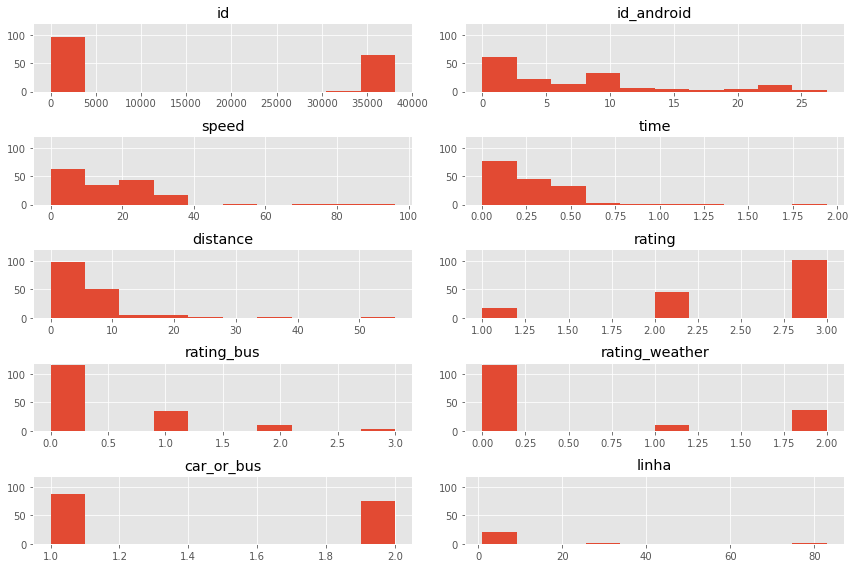

In [83]:
fig1, axes1 = plt.subplots(figsize=(12,8),nrows=5, ncols=2)
axes1_flattened = axes1.flatten()
track_colum_names = np.hstack(tracks.columns)

i = 0
for ax in axes1_flattened:
    if i != tracks.shape[1]-1:
        ax.hist(tracks[track_colum_names[i]])
        ax.set_title(track_colum_names[i])
        ax.set_ylim(0,120)
        i = i + 1
    else:
        ax.hist(tracks["linha"].value_counts())
        ax.set_title(track_colum_names[i])
        ax.set_ylim(0,120)
        i = i + 1
fig1.tight_layout();

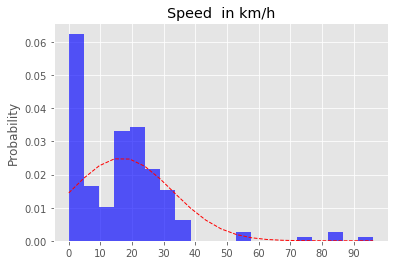

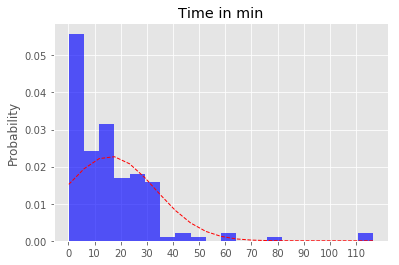

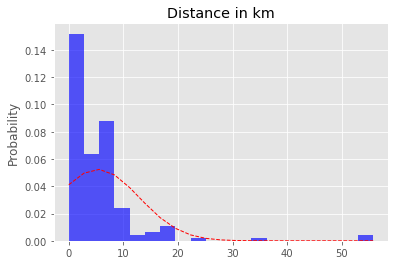

In [244]:
import matplotlib.mlab as mlab

def generate_hist_density_plot(data, label):
    n, bins, patches = plt.hist(data, 20, normed=1, histtype='bar',facecolor='b', alpha=0.65)
    mean = np.mean(data)
    std = np.std(data)
    
    # add a 'best fit' line
    y = mlab.normpdf( bins, mean, std)
    l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.ylabel('Probability')
    plt.title(label)
    plt.xticks(np.arange(0,max(data),10))
    plt.grid(True)
    return plt

generate_hist_density_plot(tracks['speed'], 'Speed  in km/h').show()
generate_hist_density_plot(tracks['time']*60, 'Time in min').show()
generate_hist_density_plot(tracks['distance'], 'Distance in km').show()



These plots show histograms for the 3 continuous variables. Again, we can see that there are many values close to zero. the red line indicates the proability distribution and the blue bars the number of objects in the bin

Detailed plot for string data in **linha** column:

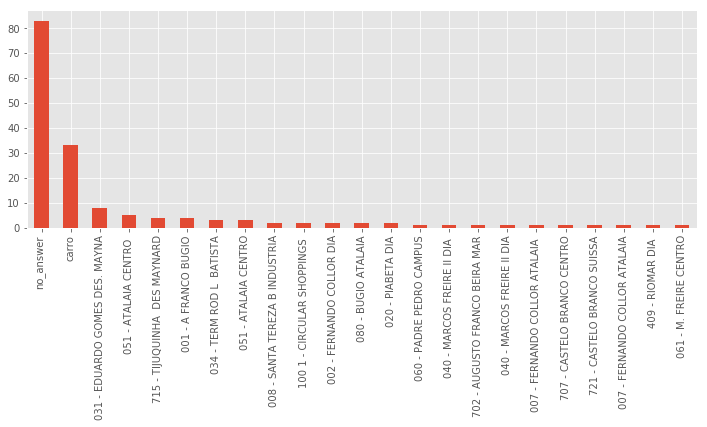

In [85]:
tracks["linha"].value_counts().plot(kind='bar',figsize=(12,4));

From this plot we can see how many people took a specific means of transport. out of 163 tracks only half of them gave an answer other than 'no_answer'

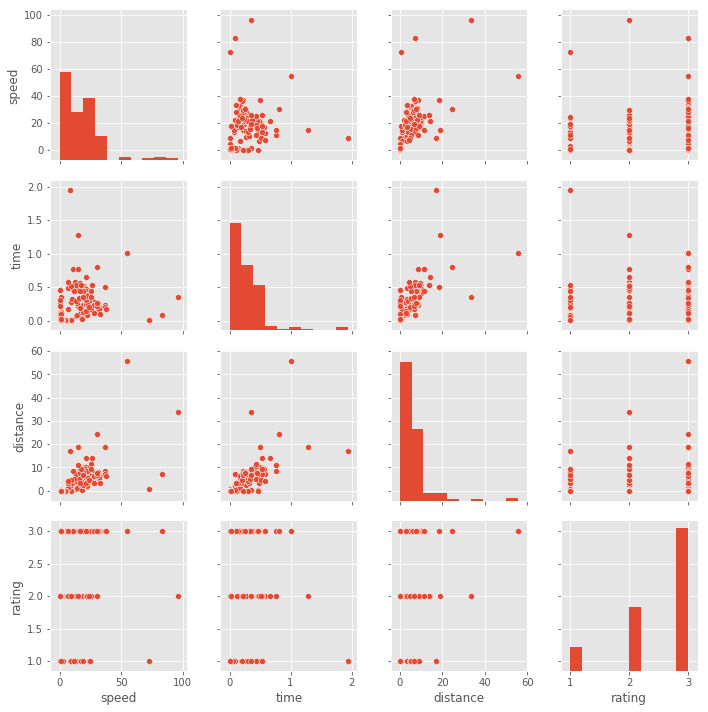

In [204]:
#get subframe
tracks_cor = tracks[['speed','time','distance','rating']]

sns.pairplot(tracks_cor);
#.show()
#sns.show()

This correlation plot for the three continuous variables and one categorical variable. One can see that there is a positive correlation between all three of these variables. Also there are several outliers with really high values in comparison to the majority of data points. maybe by removing these outliers we can see better patterns, as the data will not be as much squished to the coordinate center.

***
# Existing Issues - Potential Preprocessing Tasks
- Large discrepancy between travel time per ``track_id`` stated in the **tracks data table** and the one calculated from the **trackspoints data table**
- Remove duplicate recordings in track_ids
- remove track recordings with 0 duration
- Drop ``linha`` column due to high number of nan values



***
# To-Do - Suggestions
- id columns from **Tracks Data Table** is equal to track id column in **Trackspoints Data Table** --> perform a join between those two and visualize indivual tracks on a map 
- time series plots
- other fancy visualisation
- find clusters of similar trajectories


In [86]:
import gmplot

colors = 'red','blue','green','yellow','brown','orange','pink','purple','springgreen','firebrick'

def plottracks(track_id, color):
    latitudes = trackspoints[trackspoints['track_id'].isin([track_id])]['latitude']
    longitudes = trackspoints[trackspoints['track_id'].isin([track_id])]['longitude']
    gmap.plot(latitudes, longitudes, color, edge_width=5)

init_lat = trackspoints[trackspoints['track_id'].isin([1])]['latitude'][0]    
init_long = longitudes = trackspoints[trackspoints['track_id'].isin([1])]['longitude'][0]

gmap = gmplot.GoogleMapPlotter(init_lat, init_long, 18)
for track_id in range(1,10):
    plottracks(track_id, colors[track_id-1])
gmap.draw("map10.html")    



In [88]:
init_lat = trackspoints[trackspoints['track_id'].isin([1])]['latitude'][0]    
init_long = longitudes = trackspoints[trackspoints['track_id'].isin([1])]['longitude'][0]

heat_lats = trackspoints['latitude']
heat_lngs = trackspoints['longitude']
gmap = gmplot.GoogleMapPlotter(init_lat, init_long, 18)
gmap.heatmap(heat_lats, heat_lngs)
gmap.draw("mapHeat.html") 

In [146]:
# plot duplicate
track_points_duplicate = trackspoints[trackspoints["track_id"] == 51]
# histograms

init_lat = track_points_duplicate["latitude"].iloc[0]
init_long = track_points_duplicate["longitude"].iloc[0]

gmas = gmplot.GoogleMapPlotter(init_lat, init_long, 18)
gmas.plot(track_points_duplicate["latitude"].iloc[1:], track_points_duplicate["longitude"].iloc[1:], edge_width=5)
gmas.draw("time_less_min_t51.html")

In [104]:
import datetime as dt
# find tracks where there is a big time difference between 2 points
def find_largest_difference(track):
    biggest_diff = dt.datetime.now()
    biggest_diff = biggest_diff-biggest_diff
    
    start_id = 0
    stop_id = 0
    track_id = track.iloc[0]["track_id"]
    for p in range(1,len(track)):
        #calculate difference
        new_diff = track.iloc[p]["time"] - track.iloc[p-1]["time"]
        if new_diff > biggest_diff:
            biggest_diff = new_diff
            start_id = p-1
            stop_id = p
    largest_diff = [track_id, start_id, stop_id, biggest_diff]
    #print(biggest_diff)
    #print(start_id)
    #print(stop_id)
    return largest_diff

In [105]:
diffs = pd.DataFrame(columns=["track_id","start_id","stop_id","diff"])

max_id = trackspoints.loc[trackspoints["track_id"].idxmax()]["track_id"]

for id in range(1,max_id):
    #print(id)
    df_helper = trackspoints[trackspoints["track_id"] == id]
    if len(df_helper) != 0:
        diffs.loc[id] = find_largest_difference(df_helper)

In [92]:
#track_points_duplicate.iloc[0]["track_id"]
diffs.loc[diffs["diff"].idxmax()]

track_id                 25
start_id                  8
stop_id                   9
diff        0 days 00:22:48
Name: 25, dtype: object

In [96]:
# 20 tracks with the biggest time difference between two gps measurements
diffs.sort_values(by = ['diff'], ascending = 0).head(20)

,track_id,start_id,stop_id,diff
25,25,8,9,00:22:48
37961,37961,3,4,00:20:27
19,19,26,27,00:18:17
40,40,106,107,00:10:26
39,39,106,107,00:10:26
27,27,246,247,00:09:03
26,26,246,247,00:09:03
17,17,141,142,00:05:22
37965,37965,21,22,00:04:55
24,24,47,48,00:03:58


This list shows the 20 tracks with their single biggest time differences between two consecutive measurements. The biggest time difference is over 22 minutes.